#  Deep Learning 

## U6:  GANs  

Notebooks that accompany lectures

# 🧱 DCGAN - Bricks Data

In this notebook, we'll walk through the steps required to train your own DCGAN on the bricks dataset

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, losses, utils, metrics, optimizers

from utils import display, sample_batch

## 0. Parameters <a name="parameters"></a>

In [2]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. Prepare the data <a name="prepare"></a>

In [4]:
import tensorflow as tf
train_data = tf.keras.utils.image_dataset_from_directory(
    "/home/david/Asignaturas/MIA/DL/bricksdata/dataset",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.


In [5]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [6]:
train_sample = sample_batch(train)

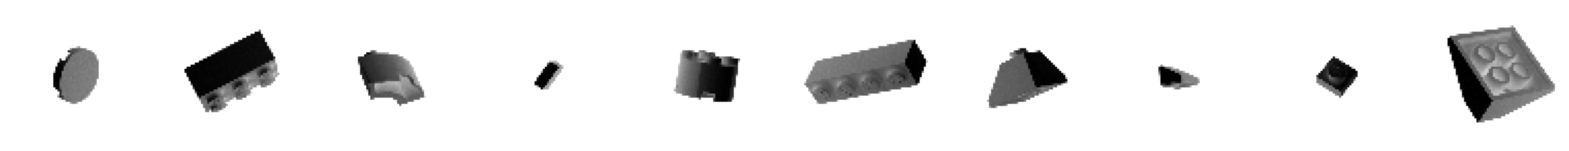

In [7]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [8]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias=False, activation="sigmoid")(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 128)      512       
 ormalization)                                                   
                                                             

In [9]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", use_bias=False, activation="tanh"
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 512)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 512)        2048      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 8, 8, 256)        2097

In [10]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(generated_images, training=True)

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(tf.shape(real_predictions))
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(tf.shape(fake_predictions))

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)

        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state([real_labels, fake_labels], [real_predictions, fake_predictions])
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [11]:
# Create a DCGAN
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)

In [12]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.ckpt")

## 3. Train the GAN <a name="train"></a>

In [13]:
dcgan.compile(
    d_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [14]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images, save_to="./output/generated_img_%03d.png" % (epoch))

Epoch 1/300


2023-04-17 18:13:35.473417: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2023-04-17 18:13:35.702317: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-17 18:13:35.702812: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-17 18:13:35.702828: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-17 18:13:35.703264: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-17 18:13:35.703340: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


313/313 [==============================] - ETA: 0s - d_loss: 0.2450 - d_real_acc: 0.8408 - d_fake_acc: 0.8599 - d_acc: 0.8504 - g_loss: 4.0017 - g_acc: 0.1401
Saved to ./output/generated_img_000.png


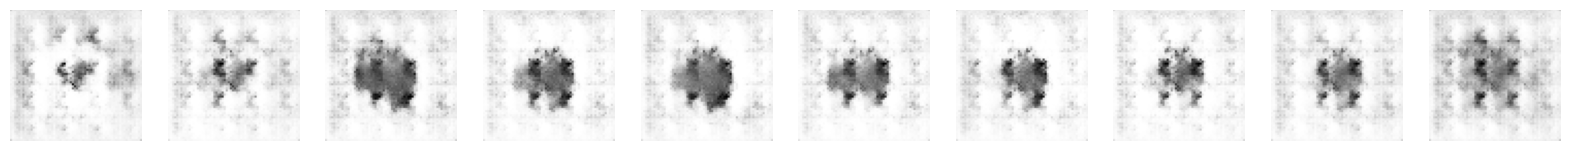

313/313 [==============================] - 26s 77ms/step - d_loss: 0.2450 - d_real_acc: 0.8408 - d_fake_acc: 0.8599 - d_acc: 0.8504 - g_loss: 4.0017 - g_acc: 0.1401
Epoch 2/300
312/313 [============================>.] - ETA: 0s - d_loss: -0.0206 - d_real_acc: 0.9128 - d_fake_acc: 0.9231 - d_acc: 0.9179 - g_loss: 5.0482 - g_acc: 0.0769
Saved to ./output/generated_img_001.png


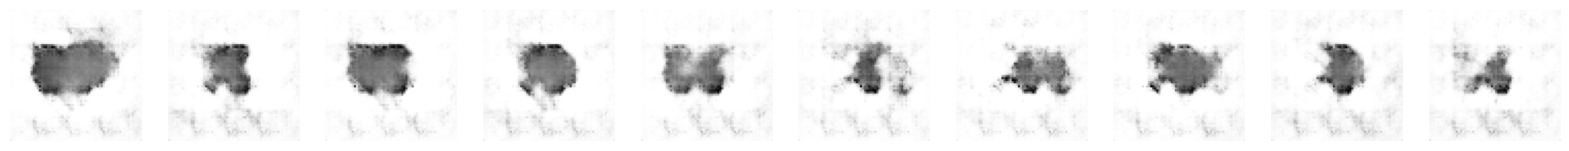

313/313 [==============================] - 25s 78ms/step - d_loss: -0.0175 - d_real_acc: 0.9129 - d_fake_acc: 0.9219 - d_acc: 0.9174 - g_loss: 5.0337 - g_acc: 0.0781
Epoch 3/300
312/313 [============================>.] - ETA: 0s - d_loss: -0.0011 - d_real_acc: 0.9075 - d_fake_acc: 0.9157 - d_acc: 0.9116 - g_loss: 6.6281 - g_acc: 0.0843
Saved to ./output/generated_img_002.png


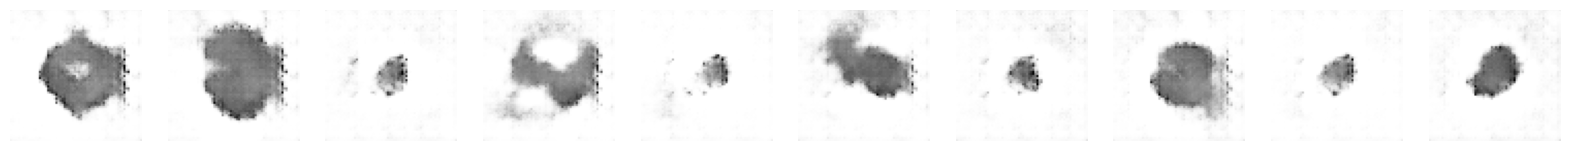

313/313 [==============================] - 25s 78ms/step - d_loss: -7.6413e-05 - d_real_acc: 0.9071 - d_fake_acc: 0.9158 - d_acc: 0.9115 - g_loss: 6.6431 - g_acc: 0.0842
Epoch 4/300
312/313 [============================>.] - ETA: 0s - d_loss: 0.1039 - d_real_acc: 0.8831 - d_fake_acc: 0.8841 - d_acc: 0.8836 - g_loss: 5.5119 - g_acc: 0.1159
Saved to ./output/generated_img_003.png


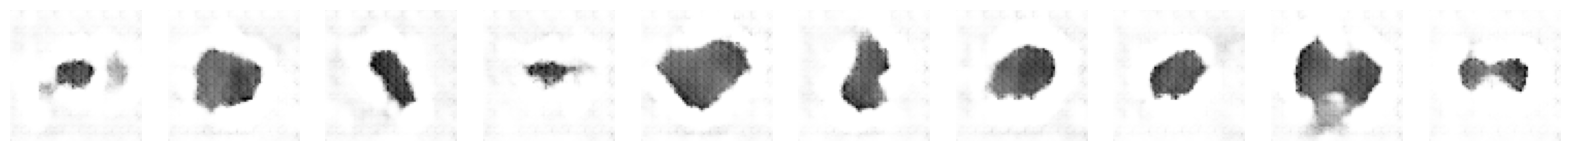

313/313 [==============================] - 25s 78ms/step - d_loss: 0.1041 - d_real_acc: 0.8829 - d_fake_acc: 0.8840 - d_acc: 0.8835 - g_loss: 5.5055 - g_acc: 0.1160
Epoch 5/300
312/313 [============================>.] - ETA: 0s - d_loss: 0.0584 - d_real_acc: 0.8957 - d_fake_acc: 0.8998 - d_acc: 0.8977 - g_loss: 5.2196 - g_acc: 0.1002
Saved to ./output/generated_img_004.png


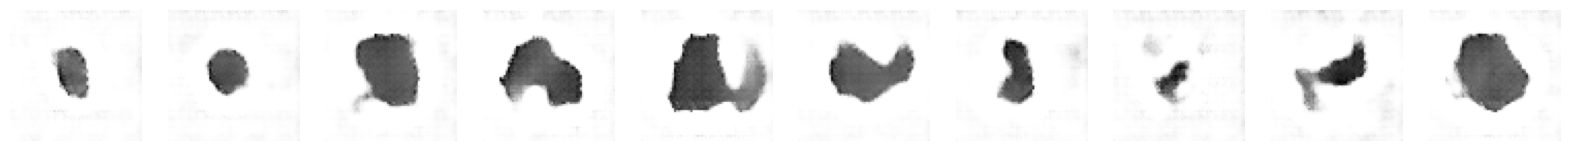

313/313 [==============================] - 25s 80ms/step - d_loss: 0.0640 - d_real_acc: 0.8959 - d_fake_acc: 0.8984 - d_acc: 0.8971 - g_loss: 5.2036 - g_acc: 0.1016
Epoch 6/300
312/313 [============================>.] - ETA: 0s - d_loss: 0.0629 - d_real_acc: 0.8934 - d_fake_acc: 0.8980 - d_acc: 0.8957 - g_loss: 4.7781 - g_acc: 0.1020
Saved to ./output/generated_img_005.png


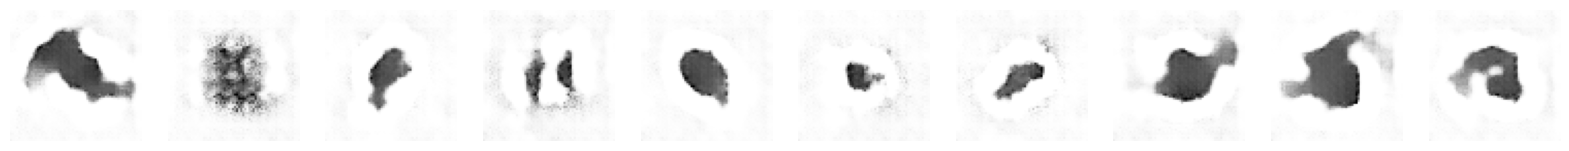

313/313 [==============================] - 26s 81ms/step - d_loss: 0.0622 - d_real_acc: 0.8935 - d_fake_acc: 0.8981 - d_acc: 0.8958 - g_loss: 4.7752 - g_acc: 0.1019
Epoch 7/300
312/313 [============================>.] - ETA: 0s - d_loss: 0.0689 - d_real_acc: 0.8982 - d_fake_acc: 0.8982 - d_acc: 0.8982 - g_loss: 4.8342 - g_acc: 0.1018
Saved to ./output/generated_img_006.png


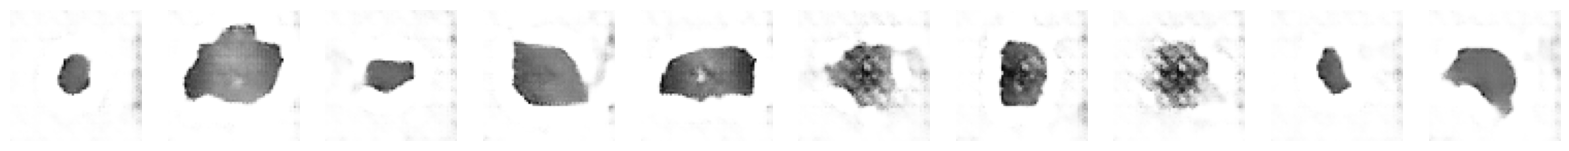

313/313 [==============================] - 25s 80ms/step - d_loss: 0.0690 - d_real_acc: 0.8978 - d_fake_acc: 0.8984 - d_acc: 0.8981 - g_loss: 4.8489 - g_acc: 0.1016
Epoch 8/300
312/313 [============================>.] - ETA: 0s - d_loss: 0.0708 - d_real_acc: 0.8967 - d_fake_acc: 0.8974 - d_acc: 0.8970 - g_loss: 4.8571 - g_acc: 0.1026
Saved to ./output/generated_img_007.png


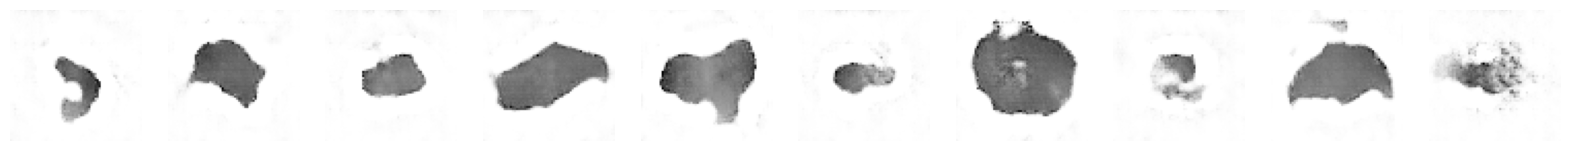

313/313 [==============================] - 25s 78ms/step - d_loss: 0.0697 - d_real_acc: 0.8969 - d_fake_acc: 0.8975 - d_acc: 0.8972 - g_loss: 4.8610 - g_acc: 0.1025
Epoch 9/300
312/313 [============================>.] - ETA: 0s - d_loss: 0.0995 - d_real_acc: 0.8941 - d_fake_acc: 0.8945 - d_acc: 0.8943 - g_loss: 4.4751 - g_acc: 0.1055
Saved to ./output/generated_img_008.png


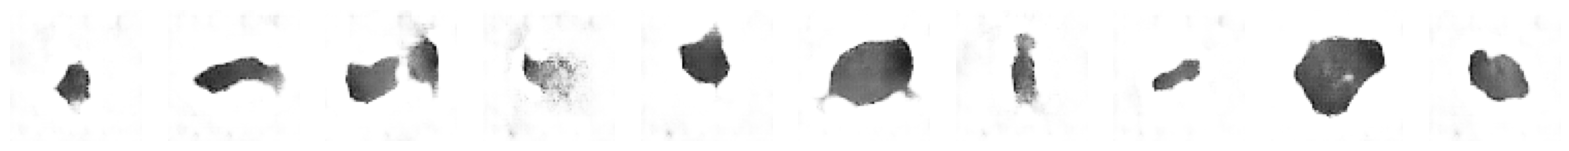

313/313 [==============================] - 25s 78ms/step - d_loss: 0.0986 - d_real_acc: 0.8943 - d_fake_acc: 0.8946 - d_acc: 0.8945 - g_loss: 4.4731 - g_acc: 0.1054
Epoch 10/300
312/313 [============================>.] - ETA: 0s - d_loss: 0.0683 - d_real_acc: 0.8993 - d_fake_acc: 0.9011 - d_acc: 0.9002 - g_loss: 4.7707 - g_acc: 0.0989
Saved to ./output/generated_img_009.png


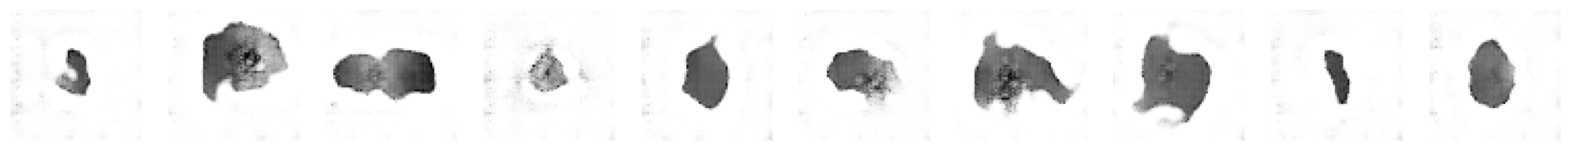

313/313 [==============================] - 25s 79ms/step - d_loss: 0.0716 - d_real_acc: 0.8995 - d_fake_acc: 0.8998 - d_acc: 0.8996 - g_loss: 4.7561 - g_acc: 0.1002
Epoch 11/300
312/313 [============================>.] - ETA: 0s - d_loss: 0.0179 - d_real_acc: 0.9135 - d_fake_acc: 0.9161 - d_acc: 0.9148 - g_loss: 4.9915 - g_acc: 0.0839
Saved to ./output/generated_img_010.png


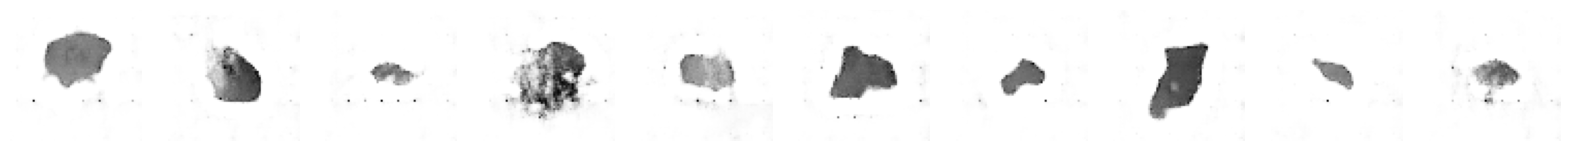

313/313 [==============================] - 25s 78ms/step - d_loss: 0.0187 - d_real_acc: 0.9136 - d_fake_acc: 0.9155 - d_acc: 0.9145 - g_loss: 4.9796 - g_acc: 0.0845
Epoch 12/300
312/313 [============================>.] - ETA: 0s - d_loss: 0.0711 - d_real_acc: 0.9014 - d_fake_acc: 0.9025 - d_acc: 0.9020 - g_loss: 4.9194 - g_acc: 0.0975
Saved to ./output/generated_img_011.png


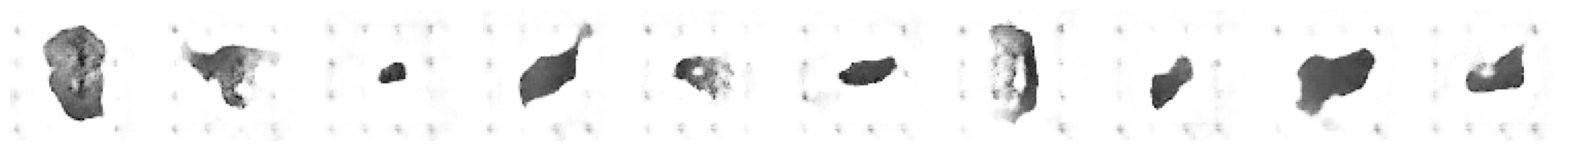

313/313 [==============================] - 25s 78ms/step - d_loss: 0.0703 - d_real_acc: 0.9016 - d_fake_acc: 0.9026 - d_acc: 0.9021 - g_loss: 4.9173 - g_acc: 0.0974
Epoch 13/300
312/313 [============================>.] - ETA: 0s - d_loss: -0.0116 - d_real_acc: 0.9204 - d_fake_acc: 0.9196 - d_acc: 0.9200 - g_loss: 5.5054 - g_acc: 0.0804
Saved to ./output/generated_img_012.png


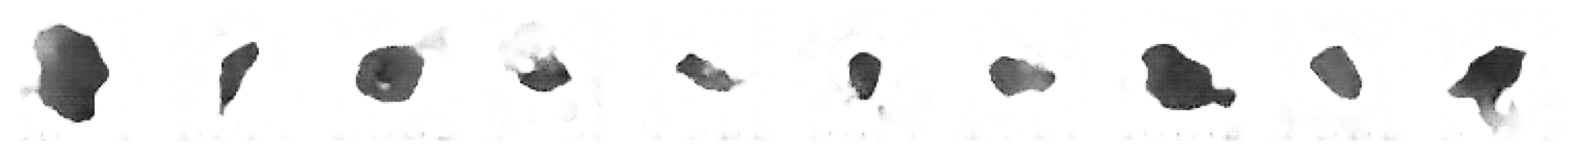

313/313 [==============================] - 25s 78ms/step - d_loss: -0.0119 - d_real_acc: 0.9205 - d_fake_acc: 0.9196 - d_acc: 0.9200 - g_loss: 5.5016 - g_acc: 0.0804
Epoch 14/300
312/313 [============================>.] - ETA: 0s - d_loss: 0.1760 - d_real_acc: 0.8501 - d_fake_acc: 0.8502 - d_acc: 0.8501 - g_loss: 4.6805 - g_acc: 0.1498
Saved to ./output/generated_img_013.png


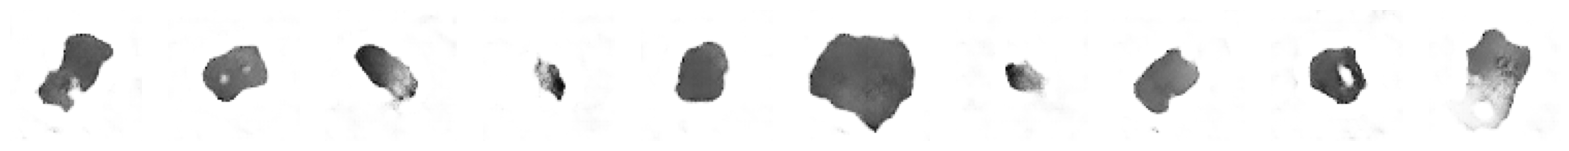

313/313 [==============================] - 25s 78ms/step - d_loss: 0.1753 - d_real_acc: 0.8502 - d_fake_acc: 0.8504 - d_acc: 0.8503 - g_loss: 4.6826 - g_acc: 0.1496
Epoch 15/300
312/313 [============================>.] - ETA: 0s - d_loss: -0.0018 - d_real_acc: 0.9133 - d_fake_acc: 0.9143 - d_acc: 0.9138 - g_loss: 5.4139 - g_acc: 0.0857   
Saved to ./output/generated_img_014.png


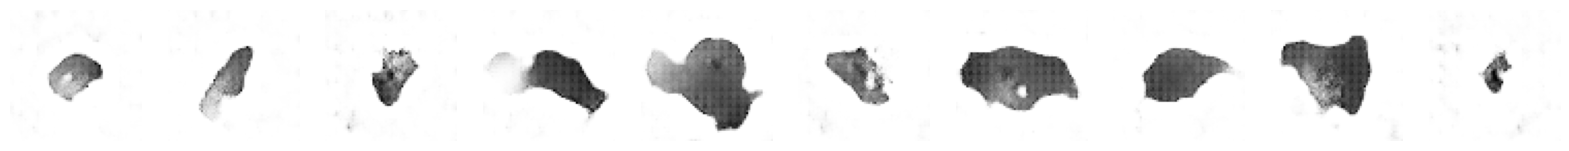

313/313 [==============================] - 25s 79ms/step - d_loss: -0.0025 - d_real_acc: 0.9133 - d_fake_acc: 0.9144 - d_acc: 0.9139 - g_loss: 5.4317 - g_acc: 0.0856
Epoch 16/300
122/313 [==========>...................] - ETA: 14s - d_loss: -0.0182 - d_real_acc: 0.9319 - d_fake_acc: 0.9314 - d_acc: 0.9316 - g_loss: 5.4329 - g_acc: 0.0686

KeyboardInterrupt: 

In [15]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[model_checkpoint_callback, tensorboard_callback, ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)

In [ ]:
# Save the final models
generator.save("./models/generator")
discriminator.save("./models/discriminator")

## 3. Generate new images <a name="decode"></a>

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

In [ ]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()